In [1]:
from gurobipy import GRB
from importlib import reload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import parameters as par
import data
import model
reload(par)

# par = {
#     'model': 'iML1515.json',
#     'biomass_rxn_id': 'BIOMASS_Ec_iML1515_core_75p37M',
#     'R': 8.3144598,
#     'T': 310.15,
#     'uptake_rate': 10,
    
    
# }

GEM = data.prepareGEM(path_to_GEM=f'{par.work_directory}/{par.model}',
                      carbon_source=par.carbon_source,
                      uptake_rate=par.uptake_rate,
                      loopless=False,
                      biomass_reaction_id=par.biomass_rxn_id)

dG0_data = data.getFreeEnergyData(GEM,
                                  work_directory=par.work_directory,
                                  pH_i=par.pH_i,
                                  Ionic_strength=par.Ionic_strength,
                                  dG0_uncertainty_threshold=par.alpha)

Fragments already downloaded
Fragments already downloaded
Using license file C:\Users\tinta\gurobi.lic
Academic license - for non-commercial use only
Read LP format model from file C:\Users\tinta\AppData\Local\Temp\tmpuu4ikt7n.lp
Reading time = 0.02 seconds
: 1147 rows, 4276 columns, 17168 nonzeros


In [2]:
reload(par)
opt_model = model.optimizeGEM(GEM, par.biomass_rxn_id) # Loopless fva no biomass flux!

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 1147 rows, 2138 columns and 8584 nonzeros
Model fingerprint: 0x30118131
Coefficient statistics:
  Matrix range     [2e-06, 8e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [7e+00, 1e+03]
  RHS range        [0e+00, 0e+00]
Presolve removed 715 rows and 1186 columns
Presolve time: 0.03s
Presolved: 432 rows, 952 columns, 5170 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3096743e+02   1.671884e+04   0.000000e+00      0s
Extra 83 simplex iterations after uncrush
     966    8.7699721e-01   0.000000e+00   0.000000e+00      0s

Solved in 966 iterations and 0.09 seconds
Optimal objective  8.769972144e-01


In [3]:
# GEM.reactions.get_by_id('BIOMASS_Ec_iML1515_core_75p37M').lower_bound = 0
# GEM.reactions.get_by_id('ATPM').lower_bound = 7

In [4]:
data.findMetaboliteByCommonName(GEM, 'fructose')

[['fru_c', 'D-Fructose'],
 ['fdp_c', 'D-Fructose 1,6-bisphosphate'],
 ['f6p_c', 'D-Fructose 6-phosphate']]

In [5]:
# Build gurobi TFBA model
reload(par)
m, variables = model.buildMILPModel(GEM, dG0_data)

# Fix internal pH (change to mM)
logx_h_c = variables['logx']['logx_h_c']
logx_h_c.lb = np.log(10**(-(par.pH_i + par.delta_pH) + 3))
logx_h_c.ub = np.log(10**(-(par.pH_i - par.delta_pH) + 3))

# Upper bound to internal h2o (mM)
logx_h2o_c = variables['logx']['logx_h2o_e']
logx_h2o_c.ub = np.log(1e2) # mM

# Upper bound to internal o2 (mM)
logx_o2_c = variables['logx']['logx_o2_c']
logx_o2_c.ub = np.log(par.maxo2) # mM

# Fix concentration of some key metabolites (Bennet2009)
# logx_atp_c = variables['logx']['logx_atp_c']
# logx_atp_c.lb = np.log(8.13e-3 * 1000)
# logx_atp_c.ub = np.log(1.14e-2 * 1000)

# logx_adp_c = variables['logx']['logx_adp_c']
# logx_adp_c.lb = np.log(4.37e-4 * 1000)
# logx_adp_c.ub = np.log(7.04e-4 * 1000)

# logx_accoa_c = variables['logx']['logx_accoa_c']
# logx_accoa_c.lb = np.log(5.29e-4 * 1000)
# logx_accoa_c.ub = np.log(6.94e-4 * 1000)

# logx_ade_c = variables['logx']['logx_ade_c']
# logx_ade_c.lb = np.log(1.26e-6 * 1000)
# logx_ade_c.ub = np.log(1.71e-6 * 1000)

# logx_fdp_c = variables['logx']['logx_fdp_c']
# logx_fdp_c.lb = np.log(1.40e-2 * 1000)
# logx_fdp_c.ub = np.log(1.64e-2 * 1000)

logx_glu_e = variables['logx']['logx_glu__L_e']
logx_glu_e.lb = np.log(20) # mM 22.2
logx_glu_e.ub = np.log(23) # mM

# Find biomass maximum under thermodynamic constraints and constraint biomass reaction
m.setObjective(variables['v']['v_' + par.biomass_rxn_id], GRB.MAXIMIZE)
m.update()
m.setParam('OutputFlag', False)
m.optimize()

try:
    print(f'Maximum flux through biomass reaction: {m.objval} mmol.min^-1.gDW^-1')
    max_biomass_flux = m.getVarByName('v_' + par.biomass_rxn_id).x
    m.getVarByName('v_' + par.biomass_rxn_id).lb = par.beta * max_biomass_flux
except:
    print('Model is infeasible!')

Maximum flux through biomass reaction: 0.8769959270024303 mmol.min^-1.gDW^-1


In [6]:
conc_sum = 0
logx_sum = 0
for var in m.getVars():
    if 'x_' in var.varName[:2]:
        conc_sum += var.x
    if 'logx_' in var.varName:
        logx_sum += var.x
total_conc_internal_mets = conc_sum - m.getVarByName('x_glu__L_e').x
print(f'Total concentration of internal metabolites: {total_conc_internal_mets} mM')
print(f'Total sum of x: {conc_sum}')
print(f'Total sum of logx: {logx_sum}')

Total concentration of internal metabolites: 280.00000008335456 mM
Total sum of x: 300.00000008335456
Total sum of logx: -4154.776576952159


In [7]:
print(f'[ATP] = {m.getVarByName("x_atp_c").x}, [ADP] = {m.getVarByName("x_adp_c").x}')

[ATP] = 0.05027557478231102, [ADP] = 0.04999874918420217


In [10]:
# Find candidate ordered metabolite pairs
reload(par)
m.update()
X_sample, candidatePairs, sampling_model = model.findCandidatePairs(m, n_samples=100)
print(len(candidatePairs))

import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

17214
Current date and time : 
2020-03-28 22:32:42


In [25]:
import pickle

def saveToPickleFile(python_object, path_to_file='object.pkl'):
    """
    Save python object to pickle file
    """
    out_file = open(path_to_file,'wb')
    pickle.dump(python_object, out_file)
    out_file.close()
    
def readFromPickleFile(path_to_file='object.pkl'):
    """
    Load python object from pickle file.
    Returns python object.
    """
    in_file = open(path_to_file,'rb')
    python_object = pickle.load(in_file)
    return python_object

In [29]:
saveToPickleFile(X_sample, path_to_file='X_sample.pkl')

In [ ]:
np.array([sum([np.e**logx for logx in X_sample[:, i]]) for i in range(X_sample.shape[1])])

In [11]:
import pandas as pd
systems_df = pd.read_excel(f'{par.work_directory}/iML1515_subsystems.xlsx')

#     central_metabolism = ['Carbohydrate metabolism', 'Amino acid metabolism',
#                      'Nucleotide metabolism', 'Lipid metabolism']
central_metabolism = ['Carbohydrate metabolism']
central_metabolites = data.findMetabolitesInPathways(GEM, systems_df,
                                                central_metabolism)
print(len(central_metabolites))

141


In [12]:
centralCandidatePairs = []
for pair in candidatePairs:
    met_i, met_j = pair
    if met_i in central_metabolites and met_j in central_metabolites:
        centralCandidatePairs.append(pair)
len(centralCandidatePairs)

1204

In [14]:
# Evaluate metabolite orders from candidate pairs
ordered_pairs = model.findConcentrationOrderedPairs(sampling_model, centralCandidatePairs[:10])

In [97]:
ordered_pairs

[('dhap_c', 'h_c'),
 ('dhap_c', 'glyc3p_c'),
 ('dhap_c', 'nad_c'),
 ('dhap_c', 'g3p_c')]

In [15]:
model.findConcentrationOrderedPairs(sampling_model, centralCandidatePairs[:2])

[]

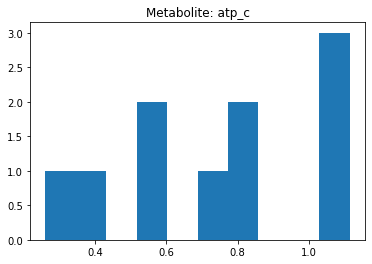

In [33]:
import matplotlib.pyplot as plt
i, j = 354, 242
plt.hist(np.e**(X_sample[i,:]))
plt.title(f'Metabolite: {mets[i]}')
plt.plot()

[]

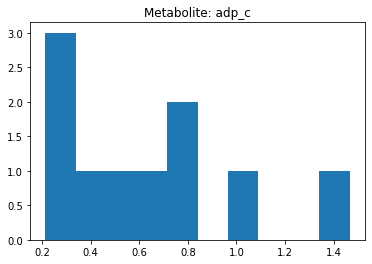

In [35]:
plt.hist(np.e**(X_sample[j,:]))
plt.title(f'Metabolite: {mets[j]}')
plt.plot()

In [147]:
import numpy as np
def generateRandomWithSum(n, sum_value=100):
    x = np.random.rand(n)
    return sum_value * (x / x.sum())
    
    
x = generateRandomWithSum(1500, sum_value=300)
logx = [np.log(x_i) for x_i in x]
xlogx = [x_i * np.log(x_i) for x_i in x]
print(f'sum_logx: {sum(logx)}, sum_xlogx: {sum(xlogx)}')

sum_logx: -2850.6867946563325, sum_xlogx: -426.89378850911316


In [138]:
x_min, x_max = 1e-3, 1e-1
x = (x_max - x_min) * np.random.rand(10000) + x_min
print(f'sum of x = {x.sum()}')
print(f'sum logx_i = {sum([np.log(xi) for xi in x])}')
print(f'ratio sum_x/sum_logx = {x.sum() / sum([np.log(xi) for xi in x])}')

sum of x = 504.47217661461036
sum logx_i = -32638.140094920727
ratio sum_x/sum_logx = -0.015456523415472387


In [17]:
# Minimize sum_i (logx_i)
obj_str = ''
for var_id in variables['logx'].keys():
    obj_str += 1 * f'variables["logx"]["{var_id}"] +'
obj_str = obj_str[:-1]
m.setObjective(eval(obj_str), GRB.MINIMIZE)
m.setParam('OutputFlag', False)
m.update()
m.optimize()
try:
    print(f'Minimum sum of metabolite concentrations: {np.e**m.objval} mM')
except:
    print('Model is infeasible!')

Minimum sum of metabolite concentrations: 0.0 mM


In [12]:
[pair for pair in candidatePairs if 'atp_c' in pair[0] and 'adp_c' in pair[1]]

[('prbatp_c', 'nadp_c'), ('atp_c', 'nadp_c'), ('datp_c', 'nadp_c')]

In [7]:
for pair in candidatePairs:
    if (pair[1] not in 'h_c' and
       pair[0] not in 'glu__L_e'):
        print(pair)

In [49]:
for pair in candidatePairs:
    if (pair[1] not in 'h_c' and
       pair[0] not in 'atp_c' and
       pair[0] not in 'adp_c' and
       pair[0] not in 'accoa_c' and
       pair[0] not in 'fdp_c' and
       pair[0] not in 'ade_c' and
       pair[0] not in 'glu__L_e'):
        print(pair)

('5drib_c', 'ade_c')
('btcoa_c', 'ade_c')
('glu__L_e', 'accoa_c')
('glu__L_e', 'o2_c')
('glu__L_e', 'adp_c')
('glu__L_e', 'ade_c')
('hco3_c', 'ade_c')
('mobd_e', 'ade_c')
('pgp140_p', 'ade_c')


# Results so far
So far I don't get any natural ordered pairs. In fact, the ones I get are direct result of the concentration constraints I imposed. For instace, in the case of h_c I put maximum concentration of 10**(-(par.pH_i - par.delta_pH) + 3) = 1e-4 mM, which is exactly the general concentration lower bound. Thus all metabolites appeared ordered with h_c. Same goes for O2. I put maximum concentration of 0.25 mM which is lower than the minimum concentration put for accoa, adp, atp and fdp and taken from Bennet et al. Therefore, so far, concentrations are unconstrained by thermodynamics! at least with respect to the order relation...

# Considering adding constraints
Perhaps we can increase the number of ordered pairs by including additional constraints, such as a minimization of the sum of concentrations or of fluxes &mdash; similar to what Teppe et al., 2013, did. That is, we want to minimize $\sum_i {\log{x_i}}$ and/or $\sum_j{v_j}$.

Also, I should constrain the concentration of external glucose _glu__L_e_ to the level employed in the experiments carried by Bennet et al. 2009. They used 4g.L${}^{-1}$ of glucose. Glucose as a molar mass of 180.156 g·mol${}^{−1}$ so this is equivalent to 0.0222 M or 22.20 mM.

Perhaps I can constraint $\sum_i {x_i} = 300$ mM which is a value found experimentally for internal metabolites, so exclude _glu__L_e_. This value is discussed in Tepper et al, 2013 (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0075370).

Also should consider concentration of internal $H_2O$. I bet this datum is somewhere... this way I can constraint it and avoid including it within the 300 mM. Damn, but concentrations are log-transformed... so I cannot constrain them... Obviously since $\sum_i {\log{x_i}} \neq \log{\sum_i {x_i}}$. The best I got was to set lb and ub for sum_logx, but this of course does not guarantee a constant sum_x...

Well, gurobi allows to add exponential and logariyhmic constraints... don't know if practical for so many metabolites. See https://www.gurobi.com/documentation/9.0/refman/py_model_agc_exp.html or https://www.gurobi.com/documentation/9.0/refman/py_model_agc_log.html. 


Ok, so I tried exponential constraints in gurobi. It works well, although unfortunately takes a minute to solve one MILP... so not really scalable, at least on my laptop. Perhaps using log constraints instead is faster? Otherwise we can always just constraint the sum of logx...

In [39]:
# # Check if constraints satisfied
# values = {}
# for var in m.getVars():
#     if var.VarName[:2] == 'y_':
#         rxn_id = var.VarName.replace('y_', '')
#         v = m.getVarByName('v_' + rxn_id).x
#         values[rxn_id] = [var.x, v]      
# values    

In [ ]:
# GEM_mets = [met.id for met in GEM.metabolites]
# met_p, met_q = GEM_mets[0], GEM_mets[1]

# obj_str = f'variables["logx"]["logx_{met_p}"] - variables["logx"]["logx_{met_q}"]'
# m.setObjective(eval(obj_str), GRB.MINIMIZE)
# m.update()
# m.optimize()

# Output DAG

In [23]:
A_plus, total_mets = buildDAGadjacencyMatrix(GEM, centralCandidatePairs)
reduced_met_orders = removeEdgesToProton(A_plus, total_mets)
graphData = buildGraphJSONData(GEM, total_mets, reduced_met_orders)
writeOutputFiles(graphData)

 
Writing files...


In [22]:
import output
A_plus, total_mets = output.buildDAGadjacencyMatrix(GEM, centralCandidatePairs)
reduced_met_orders = output.removeEdgesToProton(A_plus, total_mets)
graphData = output.buildGraphJSONData(GEM, total_mets, reduced_met_orders)
output.writeOutputFiles(graphData)